Simple switched system with the posibility of discontinuities in the continuous state, i.e. a reset.

Noisy measurements being filtered with an IMM. 

For continuous data, the IMM is able to handle the switch.
For a jump in the continuous state, the IMM is able to handle with a higher standard deviation for the process noise. Though increasing the process noise to track the continuous state decreases the seperation in probability estimation of the discrete state.

In [1]:
import filterpy
from filterpy.kalman import KalmanFilter

import matplotlib.pyplot as plt

import numpy as np

In [2]:
np.random.seed(1234)

switching_times = [1,5]
dt = 2**-4 #choose a power of 2
Tf = 8
t0=0
x0=np.array([0])
j0=1
sigma = .01

u = [np.array([1]), np.array([-1])]

### simulate the system

In [3]:
def sim_system(resets= False, reset_size = None):
    t = t0
    j = j0
    x = x0
    m = x + np.random.normal(0,sigma)
    
    jarray =[j]
    xarray =[x]
    tarray =[t]
    marray =[m]
    
    while t <Tf:
        x = x + dt*u[j]
        t = t + dt
        if t in switching_times:
            j = (j+1)%2
            if resets:
                if reset_size is None:
                    x = x*0
                else:
                    x = x + reset_size
            
        jarray.append(j)
        tarray.append(t)
        xarray.append(x)
        marray.append(x+np.random.normal(0,sigma))
        
    t = np.asarray(tarray)
    x = np.asarray(xarray)
    j = np.asarray(jarray)
    m = np.asarray(marray)
    return t,x,j,m

In [4]:
def gen_imm(Q = np.diag([.001])):
    filters = []
    Q = Q
    R = np.diag([sigma])
    for uin in u:
        filt = KalmanFilter(dim_x = 1, dim_z = 1)
        filt.F = np.eye(len(x0)) # discrete time transition matrix
        filt.B = uin*dt
        filt.H = np.array([1])
        filt.x = x0
        filt.P *= 1e-2
      
        filt.R = R
        filt.Q = Q
        filters.append(filt)
    
    k = len(u)
    mu = np.ones(k)/k
    prob = .1
    trans = np.ones((k,k))*prob
    np.fill_diagonal(trans, 1-(k-1)*prob)
    
    imm = filterpy.kalman.IMMEstimator(filters,mu,trans)
    return imm

## Continuous trajectory (no resets)

In [5]:
t,x,j,m = sim_system(resets=False)

In [6]:
imm_xhat = []
imm_what = []

filter_x = []

imm = gen_imm()

for meas in m:
	imm.predict(u=1)
	imm.update(meas)
	imm_xhat.append(imm.x.copy())
	filter_x.append(np.hstack([imm.filters[0].x, imm.filters[1].x]))
	imm_what.append(imm.mu.copy())

imm_x = np.vstack(imm_xhat)
imm_w = np.vstack(imm_what)
filt_x = np.vstack(filter_x)

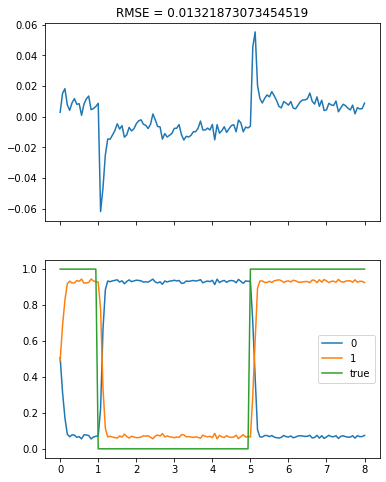

In [7]:
fig,ax= plt.subplots(2,1, figsize=(6,8), sharex=True)
ax[0].set_title('RMSE = '+str(np.sqrt(np.mean(np.power(imm_x-x,2)))))
ax[0].plot(t,imm_x-x)
ax[1].plot(t,imm_w);
ax[1].plot(t,j)
ax[1].legend(['0','1','true'])


## With resets

### Process noise $Q=.001$

 * Doesn't track continuous state after jump
 * Large seperation in discrete state probabilities

In [8]:
t,x,j,m = sim_system(resets=True)

In [9]:
imm_xhat = []
imm_what = []

filter_x = []

imm = gen_imm()

for meas in m:
	imm.predict(u=1)
	imm.update(meas)
	imm_xhat.append(imm.x.copy())
	filter_x.append(np.hstack([imm.filters[0].x, imm.filters[1].x]))
	imm_what.append(imm.mu.copy())

imm_x = np.vstack(imm_xhat)
imm_w = np.vstack(imm_what)
filt_x = np.vstack(filter_x)

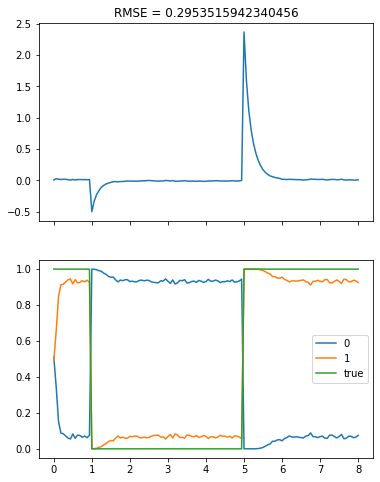

In [11]:
fig,ax= plt.subplots(2,1, figsize=(6,8), sharex=True)
ax[0].plot(t,imm_x-x)
ax[0].set_title('RMSE = '+str(np.sqrt(np.mean(np.power(imm_x-x,2)))))
ax[1].plot(t,imm_w);
ax[1].plot(t,j)
ax[1].legend(['0','1','true']);

### Process noise $Q=1$

 * Tracks continuous state after jump
 * Less steady state seperation in the discrete state

In [12]:
imm_xhat = []
imm_what = []

filter_x = []

imm = gen_imm(Q=np.array([1]))

for meas in m:
	imm.predict(u=1)
	imm.update(meas)
	imm_xhat.append(imm.x.copy())
	filter_x.append(np.hstack([imm.filters[0].x, imm.filters[1].x]))
	imm_what.append(imm.mu.copy())

imm_x = np.vstack(imm_xhat)
imm_w = np.vstack(imm_what)
filt_x = np.vstack(filter_x)

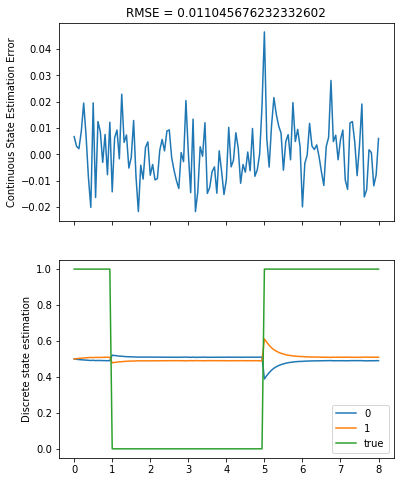

In [13]:
fig,ax= plt.subplots(2,1, figsize=(6,8), sharex=True)
ax[0].plot(t,imm_x-x)
ax[0].set_title('RMSE = '+str(np.sqrt(np.mean(np.power(imm_x-x,2)))))
ax[0].set_ylabel('Continuous State Estimation Error')
ax[1].plot(t,imm_w);
ax[1].plot(t,j)
ax[1].set_ylabel('Discrete state estimation')
ax[1].legend(['0','1','true'])
plt.show()

As the jump size increases, the process noise must increase, which decreases the seperation between the two discrete state estimation when in steady state

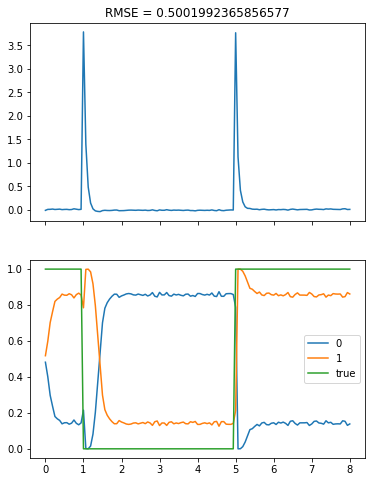

In [15]:
t,x,j,m = sim_system(resets=True, reset_size=-10)

imm_xhat = []
imm_what = []

filter_x = []

imm = gen_imm(Q=np.array([.01]))

for meas in m:
	imm.predict(u=1)
	imm.update(meas)
	imm_xhat.append(imm.x.copy())
	filter_x.append(np.hstack([imm.filters[0].x, imm.filters[1].x]))
	imm_what.append(imm.mu.copy())

imm_x = np.vstack(imm_xhat)
imm_w = np.vstack(imm_what)
filt_x = np.vstack(filter_x)

fig,ax= plt.subplots(2,1, figsize=(6,8), sharex=True)
ax[0].plot(t,imm_x-x)
ax[0].set_title('RMSE = '+str(np.sqrt(np.mean(np.power(imm_x-x,2)))))
ax[1].plot(t,imm_w);
ax[1].plot(t,j)
ax[1].legend(['0','1','true'])
plt.show()